In [227]:
## Import and data processing

import json

import pandas as pd
import numpy as np


with open('sreality/output.json') as data_file: data = json.load(data_file)    
df = pd.io.json.json_normalize(data)

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 30)

df.shape

(981, 14)

In [228]:
df.head(3)

,id,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi
0,2558665052,"Kloboukova, Praha 4 - Chodov",",vytah",False,83,3. podlaží z celkem 6 včetně 1 podzemního,4 290 000 Kč,veryGood,panelova,"Lodžie,Panelová,Částečně vybavený",C,3+1/praha-chodov-kloboukova/2558665052,3+1,osobni
1,2667434332,"Družstevní, Praha 4 - Nusle",,False,43,3. podlaží z celkem 5 včetně 1 podzemního,3 990 000 Kč,afterRec,cihlova,"Po rekonstrukci,Lodžie,Vybavený",C,2+kk/praha-nusle-druzstevni/2667434332,2+kk,osobni
2,3520147804,"Menclova, Praha 8 - Libeň","balkon,vytah",False,NaN,NaN,6 321 430 Kč,NaN,ostatni,Ve výstavbě,No,2+kk/praha-liben-menclova/3520147804,2+kk,osobni


In [229]:
df.index = df['id'].apply(pd.to_numeric)
del df['id']

# Column names:
df.columns

Index([u'location', u'navic', u'novostavba', u'plocha', u'podlazi', u'price',
       u'stavOb', u'stavba', u'stitky', u'trida', u'url', u'velikost',
       u'vlastnictvi'],
      dtype='object')

In [230]:
df['location'].value_counts()[:5]

Štolcova, Praha 4 - Modřany           18
Kolbenova, Praha 9 - Vysočany         17
Rohanské nábřeží, Praha 8 - Karlín    13
Voctářova, Praha - Praha 8            12
Libeňský ostrov, Praha 8 - Libeň       9
Name: location, dtype: int64

In [231]:
df['vlastnictvi'].value_counts()

osobni           894
druzstevni        85
statni-obecni      2
Name: vlastnictvi, dtype: int64

In [232]:
df[df['price'] == u'Info o ceně u RK'][:3]

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi
id,,,,,,,,,,,,,
3466731868,"Na Výrovně, Praha 5 - Stodůlky",",garaz,vytah",False,45,4. podlaží z celkem 5,Info o ceně u RK,veryGood,ostatni,"Balkon,Garáž,Vybavený",G,2+kk/praha-stodulky-na-vyrovne/3466731868,2+kk,osobni
3161796956,"Ke Kamýku, Praha - Kamýk",lodzie,True,106,2. podlaží z celkem 3,Info o ceně u RK,Novostavba,cihlova,,B,3+kk/praha-kamyk-ke-kamyku/3161796956,3+kk,osobni
80159068,"Jílovská, Praha - Praha 4",lodzie,False,64,10. podlaží z celkem 11,Info o ceně u RK,afterRec,panelova,"Po rekonstrukci,Panelová",No,3+1/praha-praha-4-jilovska/80159068,3+1,osobni


In [233]:
# Removing our 'priceless' offers
df = df[df['price'] != u'Info o ceně u RK']

In [234]:
df['price'] = df['price'].map(lambda x: x[:x.find(u' Kč')].replace(' ',''))

In [235]:
# converting price to int64
df['price'] = pd.to_numeric(df['price'], errors='coerce')

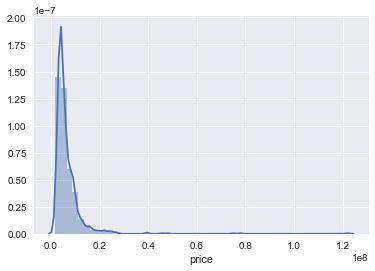

In [236]:
%matplotlib inline
import seaborn as sns
# price destribution
sns.distplot(df['price']);

In [237]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 8.731987
Kurtosis: 117.201948


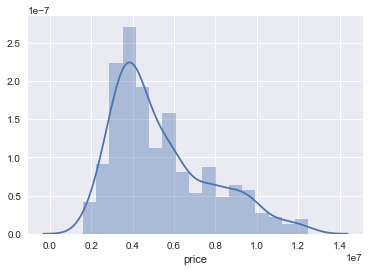

In [238]:
df = df[df['price'] < 12500000]
df = df[df['price'] > 1500000]
sns.distplot(df['price']);

In [239]:
#skewness and kurtosis
print("Skewness: %f" % df['price'].skew())
print("Kurtosis: %f" % df['price'].kurt())

Skewness: 0.922978
Kurtosis: 0.087664


In [240]:
# overall info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 875 entries, 2558665052 to 3837731164
Data columns (total 13 columns):
location       875 non-null object
navic          875 non-null object
novostavba     875 non-null object
plocha         728 non-null object
podlazi        728 non-null object
price          875 non-null int64
stavOb         836 non-null object
stavba         875 non-null object
stitky         875 non-null object
trida          875 non-null object
url            875 non-null object
velikost       875 non-null object
vlastnictvi    875 non-null object
dtypes: int64(1), object(12)
memory usage: 95.7+ KB


## Filling missing fields

### Užitná plocha

In [241]:
df['plocha'] = pd.to_numeric(df['plocha'], errors='coerce')

### Lodžie, Novostavba, sklep, parkovani

In [242]:
def contains_converter(mapping, param):
    for i in mapping:        
        if param.find(i) > -1:
            return mapping[i]
    return 'no'
balcony_mapping = {
        u'balkon':u'balkon',
        u'lodzie':u'lodzie',
        u'terasa':u'terasa'    
    }

df['sklep'] = df['navic'].str.contains('sklep')
df['parkovani'] = df['navic'].str.contains('parkovani')
df['vytah'] = df['navic'].str.contains('vytah')
df['balkon'] = df['navic'].map(lambda x: contains_converter(balcony_mapping, x))
df.head(3)

,location,navic,novostavba,plocha,podlazi,price,stavOb,stavba,stitky,trida,url,velikost,vlastnictvi,sklep,parkovani,vytah,balkon
id,,,,,,,,,,,,,,,,,
2558665052,"Kloboukova, Praha 4 - Chodov",",vytah",False,83.0,3. podlaží z celkem 6 včetně 1 podzemního,4290000,veryGood,panelova,"Lodžie,Panelová,Částečně vybavený",C,3+1/praha-chodov-kloboukova/2558665052,3+1,osobni,False,False,True,no
2667434332,"Družstevní, Praha 4 - Nusle",,False,43.0,3. podlaží z celkem 5 včetně 1 podzemního,3990000,afterRec,cihlova,"Po rekonstrukci,Lodžie,Vybavený",C,2+kk/praha-nusle-druzstevni/2667434332,2+kk,osobni,False,False,False,no
3520147804,"Menclova, Praha 8 - Libeň","balkon,vytah",False,NaN,NaN,6321430,NaN,ostatni,Ve výstavbě,No,2+kk/praha-liben-menclova/3520147804,2+kk,osobni,False,False,True,balkon


### metro and public transport

In [243]:
#TODO add lastfloor, transport
df = df.dropna(axis=0, how='any')
df.isnull().any()

location       False
navic          False
novostavba     False
plocha         False
podlazi        False
price          False
stavOb         False
stavba         False
stitky         False
trida          False
url            False
velikost       False
vlastnictvi    False
sklep          False
parkovani      False
vytah          False
balkon         False
dtype: bool

In [244]:
df['floor'] = df['podlazi'].map(lambda x: x[:x.find(u'. podlaží z celkem ')].replace(' ',''))
df['firstFloor'] = df['floor'].map(lambda x: True if x == '1' else False)
df['floor'].value_counts()

2     128
1     116
3     108
4     102
5      79
6      58
7      35
8      33
9      15
10     11
11      4
18      3
13      3
-1      3
12      2
15      2
14      1
16      1
Name: floor, dtype: int64

In [245]:
df.info()
df.to_csv('priceRaw.csv', encoding = 'utf-8')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 704 entries, 2558665052 to 3837731164
Data columns (total 19 columns):
location       704 non-null object
navic          704 non-null object
novostavba     704 non-null object
plocha         704 non-null float64
podlazi        704 non-null object
price          704 non-null int64
stavOb         704 non-null object
stavba         704 non-null object
stitky         704 non-null object
trida          704 non-null object
url            704 non-null object
velikost       704 non-null object
vlastnictvi    704 non-null object
sklep          704 non-null bool
parkovani      704 non-null bool
vytah          704 non-null bool
balkon         704 non-null object
floor          704 non-null object
firstFloor     704 non-null bool
dtypes: bool(4), float64(1), int64(1), object(13)
memory usage: 90.8+ KB


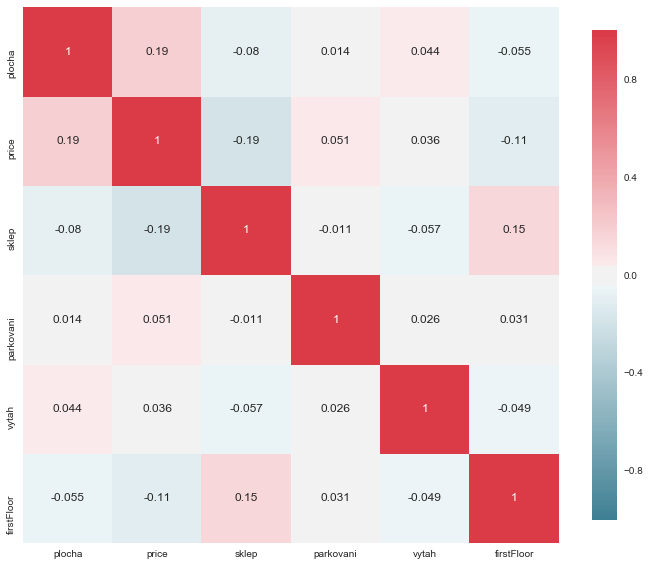

In [246]:
import matplotlib.pyplot as plt

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
    
plot_correlation_map(df)

## Model training

In [247]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def encode_with_LabelEncoder(df, column_name):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column_name])
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)
    return label_encoder

def encode_with_existing_LabelEncoder(df, column_name, label_encoder):
    df[column_name+'_le'] = label_encoder.transform(df[column_name])
    df.drop([column_name], axis=1, inplace=True)

def encode_with_OneHotEncoder_and_delete_column(df, column_name):
    le_encoder = encode_with_LabelEncoder(df, column_name)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder), le_encoder

def encode_with_OneHotEncoder_using_existing_LabelEncoder_and_delete_column(df, column_name, le_encoder):
    encode_with_existing_LabelEncoder(df, column_name, le_encoder)
    return perform_dummy_coding_and_delete_column(df, column_name, le_encoder)

def perform_dummy_coding_and_delete_column(df, column_name, le_encoder):
    oh_encoder = OneHotEncoder(sparse=False)
    oh_features = oh_encoder.fit_transform(df[column_name+'_le'].values.reshape(-1,1))
    ohe_columns=[column_name + '=' + le_encoder.classes_[i] for i in range(oh_features.shape[1])]

    df.drop([column_name+'_le'], axis=1, inplace=True)

    df_with_features = pd.DataFrame(oh_features, columns=ohe_columns)
    df_with_features.index = df.index
    return pd.concat([df, df_with_features], axis=1)

In [248]:
X = df.drop({'price','navic','stitky','url','podlazi'}, axis=1)
Y = df['price']

def encode_all(X1):
    novostavba_le_converter = encode_with_LabelEncoder(X1,'novostavba')
    X1, balcony_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'balkon')
    X1, stavba_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'stavba')
    X1, velikost_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'velikost')
    X1, vlastnictvi_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'vlastnictvi')
    X1, location_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'location')
    X1, stav_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'stavOb')
    X1, floor_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'floor')
    X1, trida_le_encoder = encode_with_OneHotEncoder_and_delete_column(X1,'trida')
    sklep_le_encoder = encode_with_LabelEncoder(X1,'sklep')
    parkovani_le_encoder = encode_with_LabelEncoder(X1,'parkovani')
    vytah_le_encoder = encode_with_LabelEncoder(X1,'vytah')
    firstFloor_le_encoder = encode_with_LabelEncoder(X1,'firstFloor')
    return X1

X = encode_all(X)

RFG test

In [249]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import KFold
from sklearn.model_selection  import cross_val_score
n_folds = 7
records_count = Y.count()
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

In [250]:
%%time
from sklearn.model_selection import GridSearchCV
scores = list()
scores_std = list()


def determine_q(clf):
    score = cross_val_score(clf, X, Y, scoring='r2', cv=kf)
    scores.append(np.mean(score))
    scores_std.append(np.std(score))
    return score.mean()
    

CPU times: user 16 µs, sys: 7 µs, total: 23 µs
Wall time: 21.9 µs


In [251]:
clf = RandomForestRegressor(n_estimators = 51, random_state=1)
clf.fit(X, Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=51, n_jobs=1, oob_score=False, random_state=1,
           verbose=0, warm_start=False)

In [252]:
determine_q(clf)

0.73198942739172423

In [253]:
# top 20 features:
features = X.columns.values
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

for i in range(num_to_plot):
    print features[feature_indices[i]], round(importances[indices[i]],4)

novostavba_le 0.692
velikost=1+1 0.0708
location=Národní obrany, Praha 6 - Bubeneč 0.0116
location=Irská, Praha 6 - Vokovice 0.01
location=Na Pankráci, Praha 4 - Nusle 0.0077
velikost=4+1 0.0064
parkovani_le 0.006
velikost=3+1 0.0053
floor=6 0.0053
stavOb=veryGood 0.0048


In [254]:
predictions = pd.Series(clf.predict(X), index=Y.index)
res_info_forest = pd.DataFrame(columns=['Error,%',u'Error,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100
    #if np.abs(rel_error)>15:
    res_info_forest.loc[i] = pd.Series({
            'Error,%':round(rel_error,1),
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'{}/{}/'.format(' https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    
predictions[4444]

3448627.4509803923

In [255]:
%%time
import xgboost as xgb
scores = list()
scores_std = list()
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)


CPU times: user 27 µs, sys: 6 µs, total: 33 µs
Wall time: 31.9 µs


In [263]:
clf = xgb.XGBRegressor(colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=5,
                 min_child_weight=1.5,
                 n_estimators=600,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

clf.fit(X, Y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2,
       gamma=0.0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1.5, missing=None, n_estimators=600, nthread=-1,
       objective='reg:linear', reg_alpha=0.9, reg_lambda=0.6,
       scale_pos_weight=1, seed=42, silent=1, subsample=0.2)

In [264]:
determine_q(clf)

0.70312755310384234

In [265]:
predictions = pd.Series(clf.predict(X), index=Y.index)

Output results

In [266]:
res_info = pd.DataFrame(columns=['Error,%','Error forest,%',u'Error,Kč',u'Error forest,Kč',u'Price,Kč',u'Price,m²', u'URL'])
for i in Y.index:
    error = Y[i] - predictions[i]
    rel_error = error/predictions[i]*100

    #if np.abs(rel_error)>15:
    res_info.loc[i] = pd.Series({
            u'Error,%':round(rel_error,1),
            u'Error forest,%': res_info_forest['Error,%'][i],
            u'Error,Kč':'{:,}'.format(int(error)),
            u'Error forest,Kč': res_info_forest[u'Error,Kč'][i],
            u'Price,Kč':'{:,}'.format(Y[i]),
            u'Price,m²':'{:,}'.format(int(Y[i]/X['plocha'][i])),
            'URL':'<a href="{0}/{1}">{1}</a>'.format('https://www.sreality.cz/detail/prodej/byt', df['url'][i])
    })
    
# Underpriced offers
pd.options.display.max_colwidth = 100
from IPython.display import HTML
show = res_info.sort_values(by=u'Error,%')[:25]
HTML(show.to_html(escape=False))

,"Error,%","Error forest,%","Error,Kč","Error forest,Kč","Price,Kč","Price,m²",URL
2134782300,-46.8,-17.4,"-1,800,772","-431,352","2,050,000","45,555",2+1/p...
3683852636,-41.6,-2.2,"-1,280,979","-41,431","1,800,000","85,714","<a href=""https://www.sreality.cz/detail/prodej/byt/1+kk/praha-vysocany-novovysocanska/3683852636..."
1377575260,-38.6,-9.0,"-2,191,386","-344,960","3,490,000","49,154",3+1/p...
520667484,-36.9,-8.8,"-2,100,757","-346,759","3,590,000","62,982",3+k...
1987936604,-36.6,-23.4,"-2,700,465","-1,429,166","4,685,000","41,460",3+kk/...
2227384668,-36.6,-17.1,"-2,246,127","-799,874","3,890,000","51,184",...
1018728796,-36.0,-24.2,"-1,667,480","-945,265","2,967,320","41,212",2+1/praha-pra...
2887459164,-35.5,-14.3,"-1,712,791","-518,255","3,117,093","57,723","<a href=""https://www.sreality.cz/detail/prodej/byt/2+kk/praha-letnany-miroslava-hajna/2887459164..."
2823999836,-35.4,-13.1,"-1,553,780","-425,290","2,830,000","54,423",2+kk/...
2068980060,-35.3,-4.3,"-1,994,081","-164,532","3,650,000","61,864",3+kk/pr...


In [267]:
# Overpriced offers
show = res_info.sort_values(by=u'Error,%',  ascending=False)[:25]
HTML(show.to_html(escape=False))

,"Error,%","Error forest,%","Error,Kč","Error forest,Kč","Price,Kč","Price,m²",URL
145596764,81.7,24.9,"5,037,194","2,234,450","11,200,000","175,000",2+kk...
1816666460,74.2,32.6,"5,108,433","2,949,359","11,990,000","184,461",2+kk/...
4293665116,73.8,13.4,"3,651,848","1,016,882","8,600,000","128,358",2+1/praha-prah...
1237266780,61.5,25.8,"3,997,672","2,155,879","10,500,000","150,000","<a href=""https://www.sreality.cz/detail/prodej/byt/3+kk/praha-stresovice-na-orechovce/1237266780..."
1330651484,60.4,16.3,"4,688,705","1,748,098","12,450,000","109,210",3+...
1693917532,57.2,10.1,"2,536,483","641,077","6,970,000","91,710",2+...
3231461724,53.5,9.6,"3,442,941","867,882","9,884,344","128,368",3+k...
274473308,53.4,18.7,"4,298,485","1,948,737","12,350,000","119,902",3+kk...
379335004,53.3,17.9,"2,712,169","1,186,432","7,805,088","116,493",2+kk...
1315119452,52.8,13.6,"2,557,168","885,176","7,400,000","148,000","<a href=""https://www.sreality.cz/detail/prodej/byt/2+kk/praha-stare-mesto-u-obecniho-dvora/13151..."


In [268]:
predictions[4444]

3021826.0

In [269]:
res_info.to_csv('priceRes.csv', encoding = 'utf-8', index_label = 'id')